# Análisis Exploratorio de Datos – Fuentes UNID

En este notebook se realiza un análisis exploratorio de las fuentes no identificadas (UNIDs) contenidas en el archivo `unids_3F_beta_err_names.txt`. Estas fuentes no cuentan con una etiqueta de clase conocida (a diferencia de los datos ASTRO o DM simulados), pero se espera que puedan incluir candidatas a materia oscura.

Cada instancia incluye las siguientes variables:

- **E_peak**: Energía pico (sin logaritmar).
- **beta**: Curvatura espectral.
- **sigma_det**: Significancia de detección.
- **beta_Rel**: Error relativo sobre la curvatura.
- **number**: Identificador único de cada fuente.

Este análisis busca comprender la distribución de estas variables, detectar patrones, posibles agrupaciones o comportamientos atípicos que puedan indicar candidatos interesantes para detección de anomalías con modelos no supervisados como One-Class SVM.

In [14]:
# Transformación Logarítmica y Verificación de Compatibilidad - UNIDs Fermi-LAT
# TFG: Utilización de técnicas de ML a datos del satélite Fermi-Lat para detección de posibles fuentes de materia oscura
# Objetivo: Transformar datos UNIDs a escala logarítmica para compatibilidad con modelo OneClassSVM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

In [15]:
# Definir nombres de las columnas para UNIDs
unids_features = ['E_peak', 'beta', 'sigma_det', 'beta_Rel', 'number']

# Cargar los datos UNIDs
unids_df = pd.read_csv('../../data/raw/unids_3F_beta_err_names.txt', 
                       sep="\s+", names=unids_features, engine='python', skiprows=1)

print(f"Dimensiones del dataset UNIDs: {unids_df.shape}")
print(f"Número total de fuentes no identificadas: {len(unids_df)}")

Dimensiones del dataset UNIDs: (1125, 5)
Número total de fuentes no identificadas: 1125


In [16]:
# Información básica del dataset
print("\nInformación del dataset UNIDs:")
unids_df.info()


Información del dataset UNIDs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   E_peak     1125 non-null   float64
 1   beta       1125 non-null   float64
 2   sigma_det  1125 non-null   float64
 3   beta_Rel   1125 non-null   float64
 4   number     1125 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 44.1 KB


In [17]:
unids_df.describe()

,E_peak,beta,sigma_det,beta_Rel,number
count,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,6.035556,0.347647,8.310279,0.936490,562.000000
std,89.583292,0.236009,5.601328,2.808888,324.903832
min,0.000002,0.002400,4.055600,0.000900,0.000000
25%,0.376570,0.159000,5.117300,0.362970,281.000000
50%,0.811710,0.305800,6.509900,0.547970,562.000000
75%,1.702900,0.493200,9.208800,0.889688,843.000000
max,2950.500000,1.000000,50.308300,74.954225,1124.000000


In [18]:
print(f"\nPrimeras 10 fuentes UNIDs:")
unids_df.head(10)


Primeras 10 fuentes UNIDs:


,E_peak,beta,sigma_det,beta_Rel,number
0,2.512900,0.0897,7.3996,1.630992,0
1,1.478200,0.4163,5.4150,0.770838,1
2,1.596400,0.6783,10.7909,0.371222,2
3,0.930950,0.2771,7.6056,0.628654,3
4,0.444800,0.3207,4.2748,0.567509,4
5,0.514490,0.1030,4.8184,1.115534,5
6,0.055744,0.2058,5.4900,0.818270,6
7,0.363390,0.1515,6.8421,0.882508,7
8,0.518020,0.4402,8.9575,0.388460,8
9,0.400930,0.2463,4.4725,0.772229,9


In [19]:
print(f"\nÚltimas 5 fuentes UNIDs:")
unids_df.tail()


Últimas 5 fuentes UNIDs:


,E_peak,beta,sigma_det,beta_Rel,number
1120,0.002726,0.0604,4.8604,1.584437,1120
1121,1.071900,0.4291,9.3059,0.449313,1121
1122,0.248300,0.1704,14.5845,0.470070,1122
1123,0.023573,0.0633,5.1143,1.489731,1123
1124,0.754510,0.6137,5.3262,0.613492,1124


In [20]:
# Verificar el rango de IDs
print(f"\nRango de IDs de fuentes UNIDs:")
print(f"ID mínimo: {unids_df['number'].min()}")
print(f"ID máximo: {unids_df['number'].max()}")
print(f"IDs únicos: {unids_df['number'].nunique()}")

if unids_df['number'].nunique() == len(unids_df):
    print("Cada fuente UNID tiene un ID único")
else:
    print("Hay IDs duplicados en el dataset")


Rango de IDs de fuentes UNIDs:
ID mínimo: 0
ID máximo: 1124
IDs únicos: 1125
Cada fuente UNID tiene un ID único


In [21]:
# Variables de características (excluyendo el ID)
unids_feature_cols = ['E_peak', 'beta', 'sigma_det', 'beta_Rel']

print("Estadísticas descriptivas de fuentes UNIDs:")
unids_stats = unids_df[unids_feature_cols].describe()
print(unids_stats)

# Verificar valores faltantes
print(f"\nVerificación de valores faltantes:")
missing_values = unids_df.isnull().sum()
print(missing_values)

if missing_values.sum() == 0:
    print("No hay valores faltantes en el dataset UNIDs")
else:
    print("Se encontraron valores faltantes")

# Verificar valores duplicados (excluyendo el ID)
duplicates = unids_df[unids_feature_cols].duplicated().sum()
print(f"\nFilas duplicadas (sin considerar ID): {duplicates}")

Estadísticas descriptivas de fuentes UNIDs:
            E_peak         beta    sigma_det     beta_Rel
count  1125.000000  1125.000000  1125.000000  1125.000000
mean      6.035556     0.347647     8.310279     0.936490
std      89.583292     0.236009     5.601328     2.808888
min       0.000002     0.002400     4.055600     0.000900
25%       0.376570     0.159000     5.117300     0.362970
50%       0.811710     0.305800     6.509900     0.547970
75%       1.702900     0.493200     9.208800     0.889688
max    2950.500000     1.000000    50.308300    74.954225

Verificación de valores faltantes:
E_peak       0
beta         0
sigma_det    0
beta_Rel     0
number       0
dtype: int64
No hay valores faltantes en el dataset UNIDs

Filas duplicadas (sin considerar ID): 0


## Histogramas de cada variable (feature)

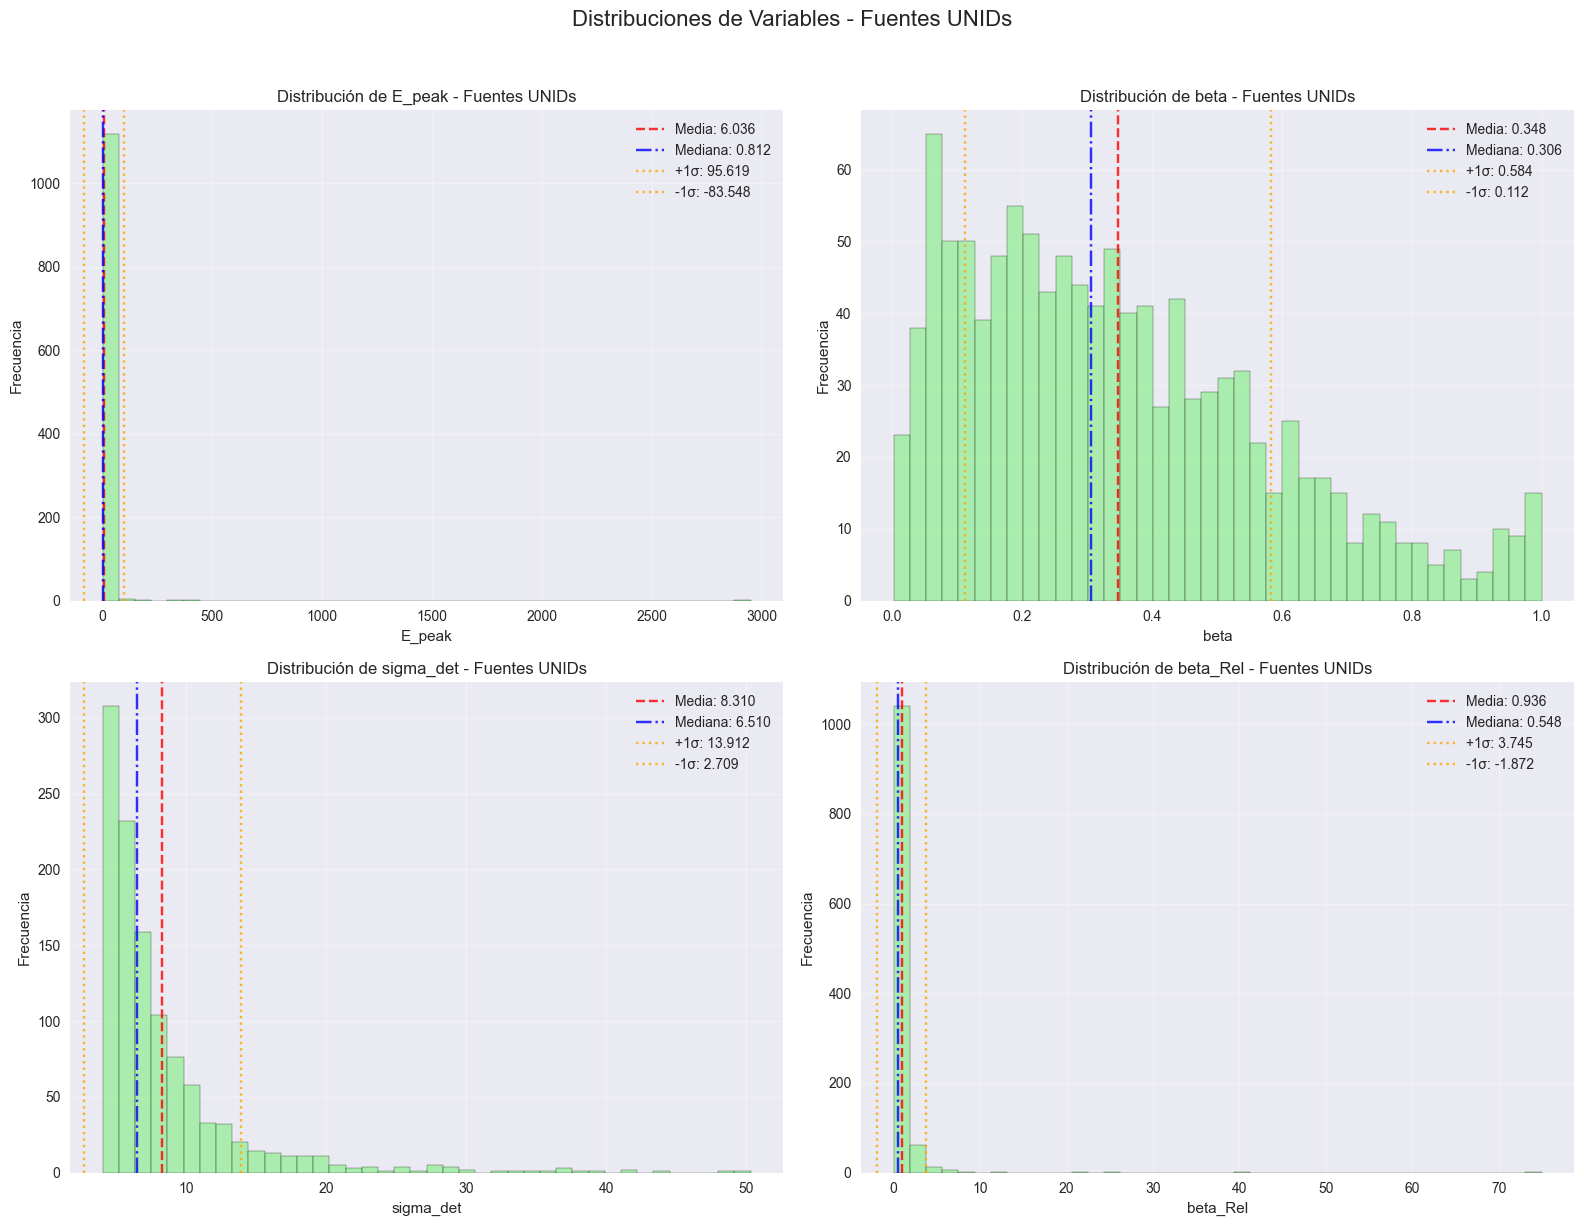

In [22]:
# Histogramas de todas las variables UNIDs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(unids_feature_cols):
    # Histograma
    axes[i].hist(unids_df[col], bins=40, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[i].set_title(f'Distribución de {col} - Fuentes UNIDs')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)
    
    # Añadir estadísticas básicas
    mean_val = unids_df[col].mean()
    std_val = unids_df[col].std()
    median_val = unids_df[col].median()
    
    axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, 
                   label=f'Media: {mean_val:.3f}')
    axes[i].axvline(median_val, color='blue', linestyle='-.', alpha=0.8, 
                   label=f'Mediana: {median_val:.3f}')
    axes[i].axvline(mean_val + std_val, color='orange', linestyle=':', alpha=0.8, 
                   label=f'+1σ: {mean_val + std_val:.3f}')
    axes[i].axvline(mean_val - std_val, color='orange', linestyle=':', alpha=0.8, 
                   label=f'-1σ: {mean_val - std_val:.3f}')
    axes[i].legend(fontsize=10)

plt.suptitle('Distribuciones de Variables - Fuentes UNIDs', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Matriz de correlación entre variables UNIDs:
             E_peak      beta  sigma_det  beta_Rel
E_peak     1.000000 -0.044607  -0.022096  0.019275
beta      -0.044607  1.000000   0.051736 -0.207150
sigma_det -0.022096  0.051736   1.000000 -0.104164
beta_Rel   0.019275 -0.207150  -0.104164  1.000000


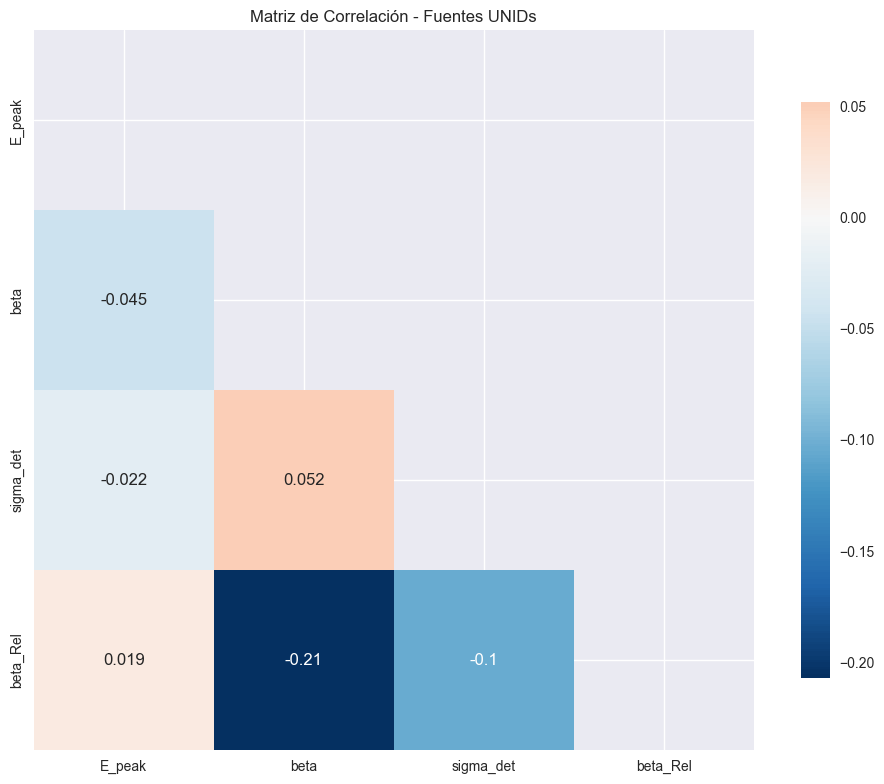

In [23]:
# Matriz de correlación para UNIDs
unids_correlation = unids_df[unids_feature_cols].corr()
print("Matriz de correlación entre variables UNIDs:")
print(unids_correlation)

# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(unids_correlation, dtype=bool))
sns.heatmap(unids_correlation, annot=True, cmap='RdBu_r', center=0, 
            square=True, mask=mask, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación - Fuentes UNIDs')
plt.tight_layout()
plt.show()

In [24]:
# Identificar correlaciones significativas
print("\nCorrelaciones significativas en UNIDs (|r| > 0.3):")
for i in range(len(unids_correlation.columns)):
    for j in range(i+1, len(unids_correlation.columns)):
        corr_val = unids_correlation.iloc[i, j]
        if abs(corr_val) > 0.3:
            print(f"{unids_correlation.columns[i]} - {unids_correlation.columns[j]}: {corr_val:.3f}")


Correlaciones significativas en UNIDs (|r| > 0.3):


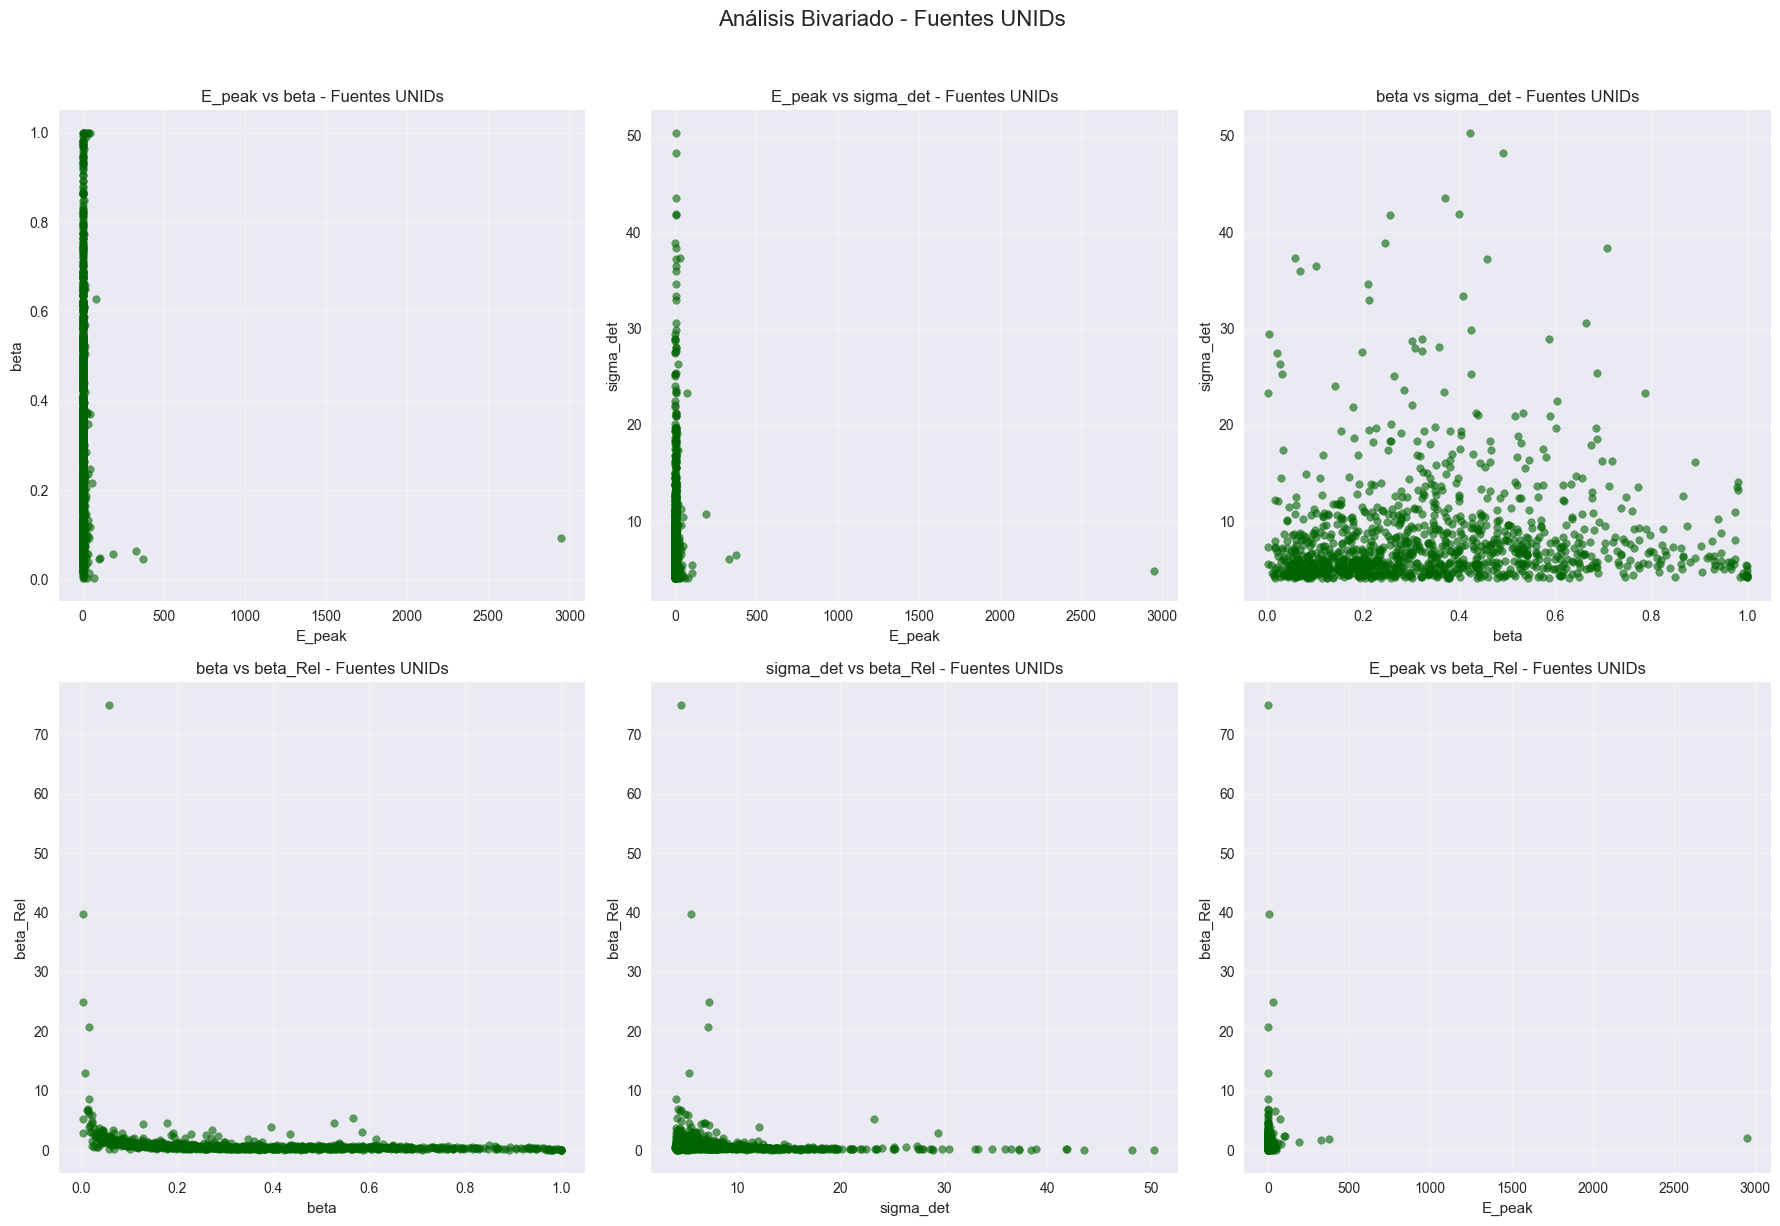

In [25]:
# Crear scatter plots para pares de variables
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Pares de variables importantes
pairs = [
    ('E_peak', 'beta'),
    ('E_peak', 'sigma_det'),
    ('beta', 'sigma_det'),
    ('beta', 'beta_Rel'),
    ('sigma_det', 'beta_Rel'),
    ('E_peak', 'beta_Rel')
]

for i, (x_var, y_var) in enumerate(pairs):
    # Scatter plot
    scatter = axes[i].scatter(unids_df[x_var], unids_df[y_var], 
                             alpha=0.6, c='darkgreen', s=30)
    
    axes[i].set_xlabel(x_var)
    axes[i].set_ylabel(y_var)
    axes[i].set_title(f'{x_var} vs {y_var} - Fuentes UNIDs')
    axes[i].grid(True, alpha=0.3)
    
    # Añadir línea de tendencia si hay correlación significativa
    if abs(unids_correlation.loc[x_var, y_var]) > 0.3:
        z = np.polyfit(unids_df[x_var], unids_df[y_var], 1)
        p = np.poly1d(z)
        axes[i].plot(unids_df[x_var], p(unids_df[x_var]), "r--", alpha=0.8,
                    label=f'r = {unids_correlation.loc[x_var, y_var]:.3f}')
        axes[i].legend()

plt.suptitle('Análisis Bivariado - Fuentes UNIDs', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [26]:
"""# Convertir las columnas a logaritmo de base 10
unids_df['E_peak'] = np.log10(unids_df['E_peak'])
unids_df['beta'] = np.log10(unids_df['beta'])
unids_df['sigma_det'] = np.log10(unids_df['sigma_det'])
unids_df['beta_Rel'] = np.log10(unids_df['beta_Rel'])
# Ver muestra
unids_df.head()"""

"# Convertir las columnas a logaritmo de base 10\nunids_df['E_peak'] = np.log10(unids_df['E_peak'])\nunids_df['beta'] = np.log10(unids_df['beta'])\nunids_df['sigma_det'] = np.log10(unids_df['sigma_det'])\nunids_df['beta_Rel'] = np.log10(unids_df['beta_Rel'])\n# Ver muestra\nunids_df.head()"

## Observaciones del Análisis Exploratorio (EDA) – Fuentes UNID

A continuación se detallan los principales hallazgos obtenidos del análisis de las variables contenidas en las fuentes no identificadas (UNIDs):

### Distribuciones de variables
- **E_peak** presenta una fuerte asimetría positiva (cola larga), con la mayoría de valores muy concentrados por debajo de 100, pero con valores extremos que superan los 1000. Esto sugiere la presencia de posibles outliers o escalas diferentes de emisión en algunas fuentes.
- **beta** muestra una distribución sesgada hacia valores bajos, con una concentración destacada entre 0.0 y 0.4. Este patrón puede estar asociado a formas espectrales más típicas, mientras que valores mayores podrían representar fuentes más inusuales.
- **beta_Rel** y **sigma_det** también muestran colas largas, lo que indica variabilidad en la calidad o fiabilidad de las mediciones espectrales.
- La transformación logarítmica de estas variables ayuda a **reducir la asimetría y comprimir outliers**, como se evidencia en la última figura (`log10(E_peak)` vs `log10(beta)`).

### Correlación entre variables
- El mapa de correlación muestra **correlaciones débiles** entre las variables (`|r| < 0.25`), lo que sugiere que estas características aportan información relativamente independiente.
- La variable `beta_Rel` está moderadamente correlacionada negativamente con `beta`, lo que podría indicar que la curvatura espectral más baja tiende a estar mejor caracterizada.

### Relaciones bivariadas
- El scatter plot `E_peak` vs `beta` evidencia **grandes concentraciones en regiones específicas del espacio**, pero también algunos puntos claramente aislados (posibles candidatos a anomalía).
- Al aplicar la escala logarítmica (`log10`), se observa un **grupo denso bien delimitado** junto con varios puntos alejados, lo que refuerza la necesidad de utilizar un modelo de detección de anomalías.

---

## Conclusión

Los datos de las fuentes UNID presentan una alta variabilidad en sus características espectrales, así como valores extremos que podrían indicar fenómenos no convencionales. Esta exploración apoya el uso de modelos de aprendizaje no supervisado, como **One-Class SVM**, para identificar observaciones que se desvíen significativamente del comportamiento de fuentes astrofísicas conocidas.
